<a href="https://colab.research.google.com/github/tarxn/ML_Si_anode/blob/main/final_basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [ ]:
 ! pip install pyDOE

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18184 sha256=76c855cbb63f3eee4abc3ca7d65f86216bb0b3646dd8b870fa86fc3a4c6c5a39
  Stored in directory: /root/.cache/pip/wheels/83/ce/8a/87b25c685bfeca1872d13b8dc101e087a9c6e3fb5ebb47022a
Successfully built pyDOE


In [ ]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from sklearn.model_selection import train_test_split

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io
import math



#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name()) 


cuda


# Tunning Parameters

In [ ]:
steps= 20000
lr=1e-3
layers = np.array([2,32,32,1]) # hidden layers
# To generate new data:
x_min=0
x_max=1
t_min=0
t_max=400
total_points_x=4000
total_points_t=4000
#Nu: Number of training points # Nf: Number of collocation points (Evaluate PDE)
Nu=1000
Nf=10000

# Auxiliary Functions


In [ ]:
def plot3D(x,t,y):
  x_plot =x.squeeze(1) 
  t_plot =t.squeeze(1)
  X,T= torch.meshgrid(x_plot,t_plot)
  F_xt = y
  fig,ax=plt.subplots(1,1)
  cp = ax.contourf(T.numpy(),X.numpy(), F_xt.numpy(),20,cmap="rainbow")
  fig.colorbar(cp) # Add a colorbar to a plot
  ax.set_title('C(x,t)')
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  plt.show()
  ax = plt.axes(projection='3d')
  ax.plot_surface(T.numpy(), X.numpy(), F_xt.numpy(),cmap="rainbow")
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  ax.set_zlabel('C(x,t)')
  plt.show()

In [ ]:
def plot3D_Matrix(x,t,y):
  X,T= x,t
  F_xt = y
  fig,ax=plt.subplots(1,1)
  cp = ax.contourf(T,X, F_xt,20,cmap="rainbow")
  fig.colorbar(cp) # Add a colorbar to a plot
  ax.set_title('C(x,t)')
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  plt.show()
  ax = plt.axes(projection='3d')
  ax.plot_surface(T.numpy(), X.numpy(), F_xt.numpy(),cmap="rainbow")
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  ax.set_zlabel('C(x,t)')
  plt.show()

## Functions

In [ ]:
# function for calculating first term
def f1(x,r0,r2,c1,c2):
    return ((r0*c1)/(r0 + x*(r2-r0))) + ((r2*c2-r0*c1)*x)/(r0 + x*(r2-r0))


# function for calculating second term used in summation
def f2(x,r0,r2,c1,c2,n,a,t):
    return ((2/((r0 + x*(r2-r0))*torch.pi))*((r2*c2*((-1)**n))-r0*c1)*(np.exp(-((n**2)*(torch.pi**2)*a*t)))*np.sin(n*torch.pi*x))/n


# function for calculating concentration at given values of r,r0,r2,t
def conc(x,t):
    r0=200*10**-9
    r2=500*10**-9
    D = 10**-16 # diffusion coefficient
    c1 = 0 # inner concentration
    c2 = 1 # outer concentration
    a = D/((r2-r0)**2) # alpha
    arr = []
    for n in range (1,50):
        arr.append(f2(x,r0,r2,c1,c2,n,a,t))
    
    sf = sum(arr)
    return f1(x,r0,r2,c1,c2) + sf
    
conc_1 = np.vectorize(conc)

### Neural Network

In [ ]:
class FCN(nn.Module):
    ##Neural Network
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
        'activation function'
        self.activation = nn.Tanh()
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)]) 
        self.iter = 0 #For the Optimizer
        'Xavier Normal Initialization'
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)   
    'foward pass'
    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        a = x.float()
        for i in range(len(layers)-2):  
            z = self.linears[i](a)              
            a = self.activation(z)    
        a = self.linears[-1](a)
        return a
    'Loss Functions'
    #Loss BC
    def lossBC(self,x_BC,y_BC):
      loss_BC=self.loss_function(self.forward(x_BC),y_BC)
      return loss_BC
    #Loss PDE
    def lossPDE(self,x_PDE):
      r0=200*10**-9
      r2=500*10**-9
      D = 10**-16
      a = D/((r2-r0)**2)
      g=x_PDE.clone()
      g.requires_grad=True #Enable differentiation
      f=self.forward(g)
      f_x_t = autograd.grad(f,g,torch.ones([g.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0] #first derivative
      f_xx_tt = autograd.grad(f_x_t,g,torch.ones(g.shape).to(device), create_graph=True)[0]#second derivative
      f_t=f_x_t[:,[1]]# we select the 2nd element for t (the first one is x) (Remember the input X=[x,t]) 
      f_x=f_x_t[:,[0]] 
      f_xx=f_xx_tt[:,[0]]# we select the 1st element for x (the second one is t) (Remember the input X=[x,t]) 
      f=f_t- a*f_xx - (2*D/(r0*(r2-r0) + g[:,0:1]*(r2-r0)*(r2-r0)))*f_x
      return self.loss_function(f,f_hat)

    def loss(self,x_BC,y_BC,x_PDE):
      w = 1
      loss_bc=self.lossBC(x_BC,y_BC)
      loss_pde=self.lossPDE(x_PDE)
      return loss_bc+ w*loss_pde

    def rel_loss(self,x_BC,y_BC,x_PDE):
      loss_bc=self.lossBC(x_BC,y_BC)
      loss_pde=self.lossPDE(x_PDE)
      return torch.sqrt(loss_bc/loss_pde)

    #Optimizer              X_train_Nu,Y_train_Nu,X_train_Nf                   
    def closure(self):
      optimizer.zero_grad()  
      loss = self.loss(X_train_Nu,Y_train_Nu,X_train_Nf)
      loss.backward()      
      self.iter += 1
      if self.iter % 100 == 0:
        loss2=self.lossBC(X_test,Y_test)
        print("Training Error:",loss.detach().cpu().numpy(),"---Testing Error:",loss2.detach().cpu().numpy())
      return loss   

# Generate data

/usr/local/lib/python3.7/dist-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


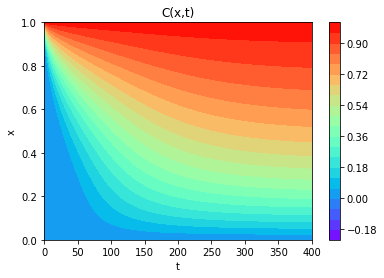

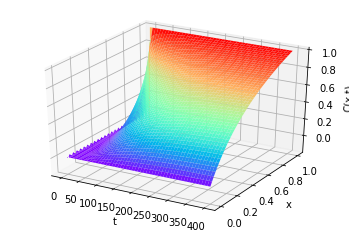

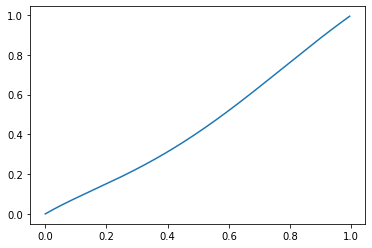

In [ ]:
x=torch.linspace(x_min,x_max,total_points_x).view(-1,1)
t=torch.linspace(t_min,t_max,total_points_t).view(-1,1)
x1= np.arange(x_min,x_max,0.005)
t1=100
# Create the mesh 
X,T=torch.meshgrid(x.squeeze(1),t.squeeze(1))
# Evaluate real function
y_real=conc(X,T)
plot3D(x,t,y_real) #f_real was defined previously(function)
plt.plot(x1,conc(x1,t1))

In [ ]:
print(x.shape,t.shape,y_real.shape)
print(X.shape,T.shape)

torch.Size([4000, 1]) torch.Size([4000, 1]) torch.Size([4000, 4000])
torch.Size([4000, 4000]) torch.Size([4000, 4000])


## Prepare Data

In [ ]:
# Transform the mesh into a 2-column vector
x_test=torch.hstack((X.transpose(1,0).flatten()[:,None],T.transpose(1,0).flatten()[:,None]))
y_test=y_real.transpose(1,0).flatten()[:,None] # Colum major Flatten (so we transpose it)
# Domain bounds
lb=x_test[0] #first value
ub=x_test[-1] #last value 
print(x_test.shape,y_test.shape)
print(lb,ub)

torch.Size([16000000, 2]) torch.Size([16000000, 1])
tensor([0., 0.]) tensor([  1., 400.])


## Training Data

In [ ]:
#Initial Condition
#Left Edge: x(x,0)=sin(x)->xmin=<x=<xmax; t=0
left_X=torch.hstack((X[:,0][:,None],T[:,0][:,None])) # First column # The [:,None] is to give it the right dimension
left_Y=torch.zeros(left_X.shape[0],1) 
#Boundary Conditions
#Bottom Edge: x=min; tmin=<t=<max
bottom_X=torch.hstack((X[0,:][:,None],T[0,:][:,None])) # First row # The [:,None] is to give it the right dimension
bottom_Y=torch.zeros(bottom_X.shape[0],1)
#Top Edge: x=max; 0=<t=<1
c2=1
top_X=torch.hstack((X[-1,:][:,None],T[-1,:][:,None])) # Last row # The [:,None] is to give it the right dimension
top_Y=c2*torch.ones(top_X.shape[0],1)
#Get all the training data into the same dataset
X_train=torch.vstack([left_X,bottom_X,top_X])
Y_train=torch.vstack([left_Y,bottom_Y,top_Y])
#Choose(Nu) points of our available training data:
idx=np.random.choice(X_train.shape[0],Nu,replace=False)
X_train_Nu=X_train[idx,:]
Y_train_Nu=Y_train[idx,:]
# Collocation Points (Evaluate our PDe)
#Choose(Nf) points(Latin hypercube)
X_train_Nf=lb+(ub-lb)*lhs(2,Nf) # 2 as the inputs are x and t
X_train_Nf=torch.vstack((X_train_Nf,X_train_Nu)) #Add the training poinst to the collocation points

In [ ]:
print("Original shapes for X and Y:",X.shape,y_real.shape)
print("Boundary shapes for the edges:",left_X.shape,bottom_X.shape,top_X.shape)
print("Available training data:",X_train.shape,Y_train.shape)
print("Final training data:",X_train_Nu.shape,Y_train_Nu.shape)
print("Total collocation points:",X_train_Nf.shape)

Original shapes for X and Y: torch.Size([4000, 4000]) torch.Size([4000, 4000])
Boundary shapes for the edges: torch.Size([4000, 2]) torch.Size([4000, 2]) torch.Size([4000, 2])
Available training data: torch.Size([12000, 2]) torch.Size([12000, 1])
Final training data: torch.Size([1000, 2]) torch.Size([1000, 1])
Total collocation points: torch.Size([11000, 2])


# Train Neural Network

In [ ]:
torch.manual_seed(123)
#Store tensors to GPU
X_train_Nu=X_train_Nu.float().to(device)#Training Points (BC)
Y_train_Nu=Y_train_Nu.float().to(device)#Training Points (BC)
X_train_Nf=X_train_Nf.float().to(device)#Collocation Points
f_hat = torch.zeros(X_train_Nf.shape[0],1).to(device)#to minimize function

X_test=x_test.float().to(device) # the input dataset (complete)
Y_test=y_test.float().to(device)# the real solution 


#Create Model
PINN = FCN(layers)
PINN.to(device)
print(PINN)
params = list(PINN.parameters())
optimizer = torch.optim.Adam(PINN.parameters(),lr=lr,amsgrad=False)
'''
'L-BFGS Optimizer'
optimizer = torch.optim.LBFGS(PINN.parameters(), lr=lr, 
                              max_iter = steps, 
                              max_eval = None, 
                              tolerance_grad = 1e-05, 
                              tolerance_change = 1e-09, 
                              history_size = 100, 
                              line_search_fn = 'strong_wolfe')'''
start_time = time.time()


FCN(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [ ]:
#optimizer.step(PINN.closure)
print(X_test)
print(Y_test)

tensor([[0.0000e+00, 0.0000e+00],
        [2.5006e-04, 0.0000e+00],
        [5.0013e-04, 0.0000e+00],
        ...,
        [9.9950e-01, 4.0000e+02],
        [9.9975e-01, 4.0000e+02],
        [1.0000e+00, 4.0000e+02]], device='cuda:0')
tensor([[ 0.0000e+00],
        [-6.2476e-04],
        [-1.2481e-03],
        ...,
        [ 9.9979e-01],
        [ 9.9989e-01],
        [ 1.0000e+00]], device='cuda:0')


In [ ]:
print("total_points_x : " + str(total_points_x))
print("total_points_t : " + str(total_points_t))
print("Nu : " + str(Nu))
print("Nf : " + str(Nf))
a_rel=0
a_train=0
a_test=0
v=10
for i in range(steps):
    if i==0:
      print("Training Loss-----Test Loss-----Relative Loss")
    loss = PINN.loss(X_train_Nu,Y_train_Nu,X_train_Nf) # use mean squared error
    rel_er= PINN.rel_loss(X_train_Nu,Y_train_Nu,X_train_Nf) #. 
    optimizer.zero_grad()
    loss.backward()
    # rel_er.backward()
    optimizer.step()
    if i%(steps/v)==0:
      with torch.no_grad():
        test_loss=PINN.lossBC(X_test,Y_test)

      re=rel_er.detach().cpu().numpy() # rel. error
      tre=loss.detach().cpu().numpy() #training error
      te= test_loss.detach().cpu().numpy() #test error
      
      a_rel = a_rel+ re
      a_train = a_train + tre
      a_test = a_test + te

      print(tre,'---',te,'---',re)
print("Average losses:")
print(round(a_train/v,15),'---',round(a_test/v,9),'---',round(a_rel/v,9))


total_points_x : 4000
total_points_t : 4000
Nu : 1000
Nf : 10000
Training Loss-----Test Loss-----Relative Loss
2.4932206e-06 --- 0.012079611 --- 0.1811349
4.167536e-06 --- 0.011728301 --- 0.36041868
1.8234612e-06 --- 0.014306119 --- 0.06603327
2.1977391e-06 --- 0.014297038 --- 0.09465053
2.3567318e-06 --- 0.015477672 --- 0.10231463
2.4950455e-06 --- 0.017459812 --- 0.123324215
2.1151375e-06 --- 0.014951933 --- 0.10442548
1.6144559e-05 --- 0.0133646345 --- 0.67222875
1.8903468e-06 --- 0.014875391 --- 0.06347352
3.073393e-06 --- 0.014986488 --- 0.21782465
Average losses:
3.875717016e-06 --- 0.0143527 --- 0.198582862


### Plots

In [ ]:
y1=PINN(X_test)

In [ ]:
x1=X_test[:,0]
t1=X_test[:,1]

In [ ]:
arr_x1=x1.reshape(shape=[total_points_x,total_points_t]).transpose(1,0).detach().cpu()
arr_T1=t1.reshape(shape=[total_points_x,total_points_t]).transpose(1,0).detach().cpu()
arr_y1=y1.reshape(shape=[total_points_x,total_points_t]).transpose(1,0).detach().cpu()
arr_y_test=y_test.reshape(shape=[total_points_x,total_points_t]).transpose(1,0).detach().cpu()

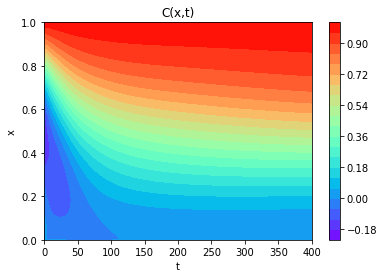

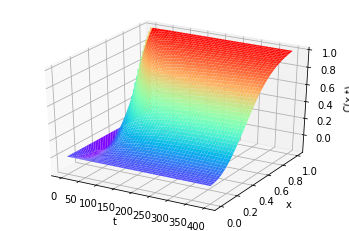

In [ ]:
plot3D_Matrix(arr_x1,arr_T1,arr_y1)

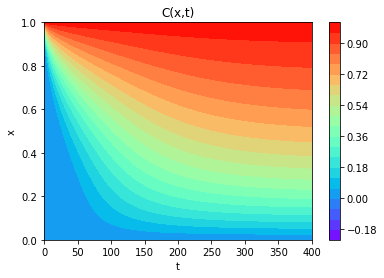

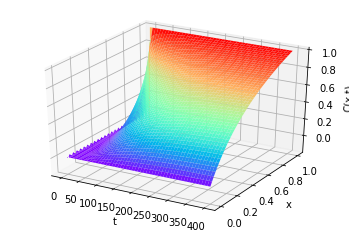

In [ ]:
plot3D_Matrix(X,T,y_real)